In [1]:
# import the libraries as shown below
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"dataset1\train",
    seed=123,
    shuffle=True,
    image_size=(224,224),
    batch_size=32
)

Found 5830 files belonging to 5 classes.


In [3]:
class_names = dataset.class_names
class_names

['Chickenpox', 'Healthy skin', 'Measles', 'Monkeypox', 'Small_Pox']

In [4]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[3 4 0 4 4 4 4 4 3 4 3 0 3 3 3 3 4 0 0 4 3 0 1 0 0 1 3 1 4 3 1 0]


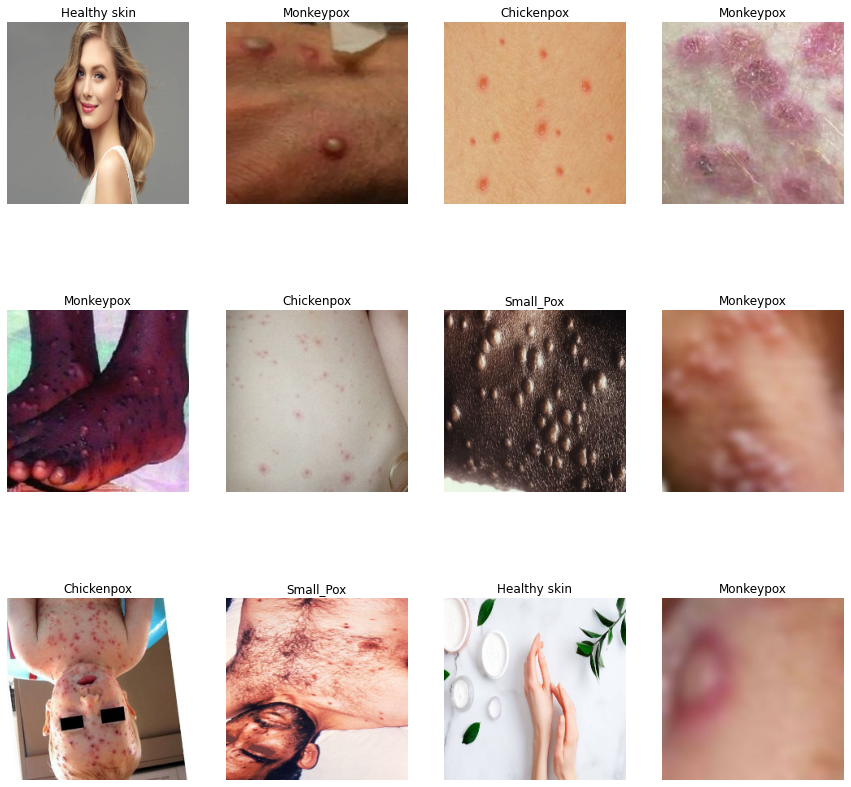

In [7]:
plt.figure(figsize=(15, 15
                   ))
for image_batch, labels_batch in dataset.take(5):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [9]:
train_path =  r"dataset1\train"
valid_path =   r"dataset1\val"

In [10]:
# add preprocessing layer to the front of VGG
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [11]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [12]:
# our layers - you can add more if you want
x = Flatten()(inception.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(5, activation='softmax')(x)

In [13]:
# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [14]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [15]:
# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
    
)

In [16]:
from keras.preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.3,
                                   zoom_range = 0.2,
                                   rotation_range=10,
                                   horizontal_flip = True)

training_generator = training_datagen.flow_from_directory(  r"dataset1\train",
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')



Found 5830 images belonging to 5 classes.


In [17]:
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range = 0.3,
        zoom_range = 0.2,
        rotation_range=10,
        horizontal_flip=True)

validation_generator = validation_datagen.flow_from_directory(
        r'dataset1/val',
        target_size=(224,224),
        batch_size=32,
        class_mode="sparse"
)

Found 727 images belonging to 5 classes.


In [18]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory( r"dataset1\test",
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')


Found 730 images belonging to 5 classes.


In [21]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

In [22]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_generator,
  validation_data=validation_generator,
  epochs=100,
  steps_per_epoch=len(training_generator),
  validation_steps=len(validation_generator),
  callbacks=[earlystopping]
)

Epoch 1/100


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [18]:
scores = model.evaluate(test_set)

11/11 [==============================] - 6s 523ms/step - loss: 2.3338 - accuracy: 0.9588


In [19]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']

loss = r.history['loss']
val_loss = r.history['val_loss']

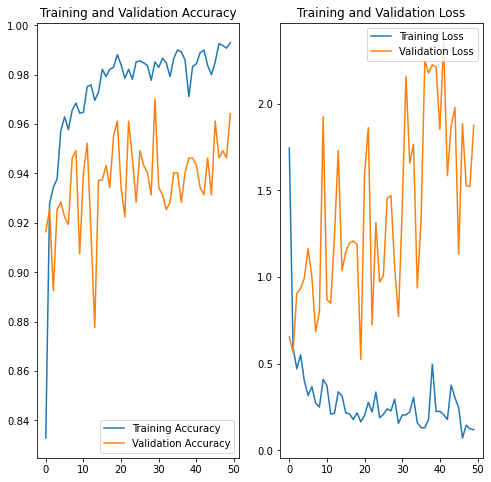

In [20]:
EPOCHS = 50

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [21]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 41ms/step


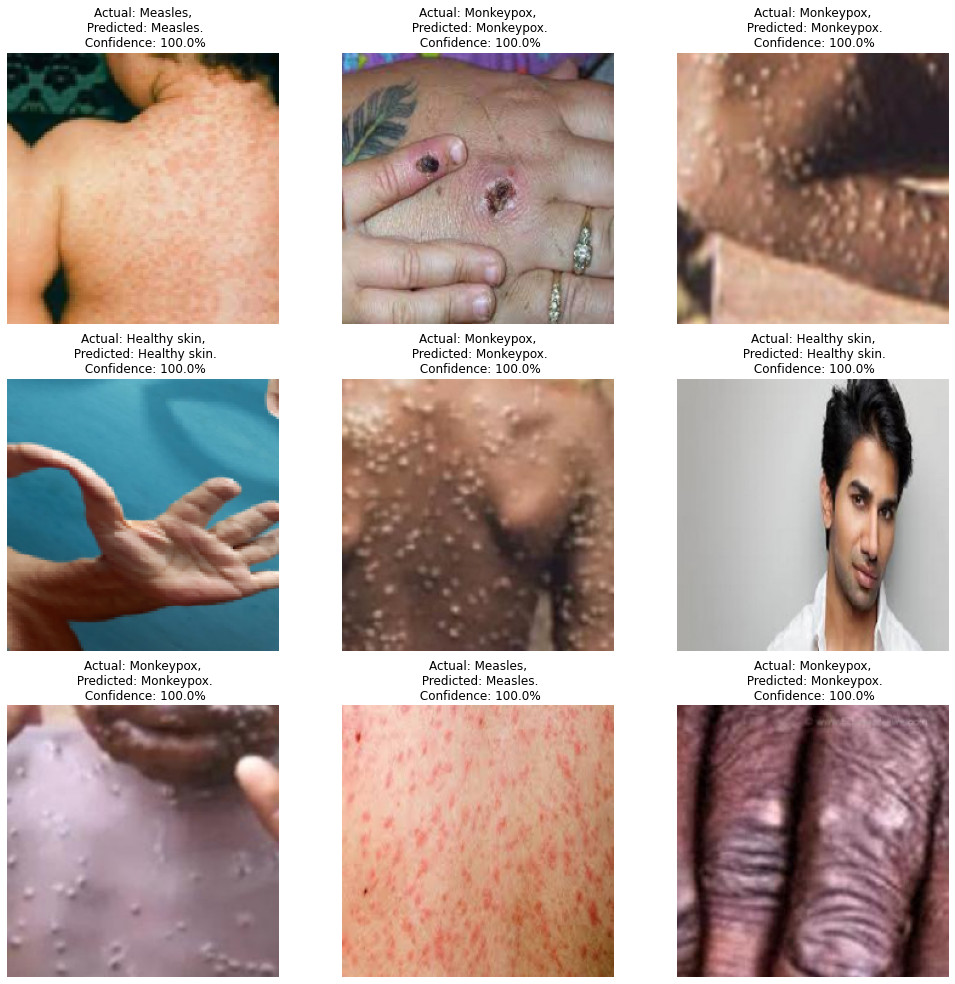

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(17, 17))
for images, labels in test_set:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break